# Thesis Hierarchical plots - 4try - Less sigmax - WITH gain norm

4/X

Sigma_x = 0.1

Randomly varying 2 parameters:
- p / sparsity
- theta / threshold for second layer ReLU.

In [47]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.signal as scsi
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress
import collections
import cPickle as pickle

from astropy import convolution as asconv

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import hierarchicalrandomnetwork

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [69]:
overwrite = False
cache_filename = ("/nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/"
                  "hierarchical_weights_ptheta_4try_repetitions10_300818/outputs/df_out.pkl")

if os.path.exists(cache_filename) and not overwrite:
    import reloader_hierarchical_weights_4try_300818 as rel
    generator_module = rel.generator_module
    dataset_infos = rel.dataset_infos
    df_all_fits = pd.read_pickle(cache_filename)
else:
    with io.capture_output(display=False, stdout=True) as captured:
        %run reloader_hierarchical_weights_4try_300818.py
        
    dataset_infos = data_pbs.dataset_infos

Reloader data generated from  generator_hierarchical_weights_4try_300818.py


In [70]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='hierarchicalrandomnetwork_characterisation')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_4try_repetitions10_300818/outputs/thesis_hier_params-<module>-457442cf-917c-40ec-ad2a-ac5fcf8d30ec ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_4try_repetitions10_300818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/hierarchicalrandomnetwork_characterisation/hierarchical_weights_ptheta_4try_repetitions10_300818_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_ptheta_4try_repetitions10_300818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/hierarchicalrandomnetwork_characterisation/hierarchical_weights_ptheta_4try_repetitions10_300818_outputs

In [71]:
# Processing data 
def avg_axis(array_name, array, axis=None, out=None):
    if out is None:
        out = []
    out.append((array_name, np.mean(array, axis=axis)))
    return out

def process_inv_var(array_name, array):
    out = []
    avg_axis(array_name, array, out=out)
    avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    return out
    
def process_marginal_fi(array_name, array):
    out = []
    
    # Marginal FI/Inv FI have (mean, std), just keep mean
    array = array[..., 0]
    avg_axis(array_name, array, out=out)
    
    if array_name.find('inv') > -1:
        avg_axis(array_name + "_stddev", (1.*array)**0.5, out=out)
    else:
        avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    
    return out

def process_em_fits(array_name, array):
    out = []
    for col_i, colname in enumerate(
            ['kappa', 'target', 'nontargets', 'random', 'LL', 'bic']):
        out = avg_axis(array_name + "_" + colname, array[col_i], out=out)
        
    out = avg_axis(array_name + '_fidelity', 1./utils.kappa_to_stddev(array[0])**2., out=out)
    out = avg_axis(array_name + '_stddev', utils.kappa_to_stddev(array[0]), out=out)
    
    return out

def construct_pandas_dataframe_flat(data_pbs, pandas_columns_with_processing, num_repetitions, overwrite=False):    
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    num_samples = len(data_pbs.loaded_data['datasets_list'])
    pandas_column_data = collections.defaultdict(list)

    load_progress = progress.Progress(num_samples)
    for i in xrange(num_samples):
        # For every sample, need to add a row with all columns
        if i % (num_samples/10) == 0:
            print "{:.1f}% {}".format(load_progress.percentage(), load_progress.time_remaining_str())

        # Extract data
        for repet_i in xrange(num_repetitions):
            # Filter completed only
            repeats_completed = data_pbs.dict_arrays.values()[0]['repeats_completed'][i]
            if repeats_completed != (num_repetitions - 1):
                continue

            for result_array_name, result_processing in pandas_columns_with_processing:
                res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'][i])[..., repet_i]

                columns_data = result_processing['process'](result_processing['name'], res_array)
                for column_name, col_data in columns_data:
                    pandas_column_data[column_name].append(col_data)

            pandas_column_data['repet'].append(repet_i)
            for param_i, param_name in enumerate(parameter_names_sorted):
                pandas_column_data[param_name].append(
                    data_pbs.dict_arrays[result_array_name]['parameters_flat'][i][param_i])

        load_progress.increment()

    df_out = pd.DataFrame(pandas_column_data)
    return df_out

In [72]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins[param_name] = np.unique(param_qbins[param_name])
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi
        
    return filter_dataframe(df, quantized_parameters_targets)

In [73]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = dataset_infos['parameters']

if not os.path.exists(cache_filename) or overwrite:
    pandas_columns_with_processing = [
        ('result_all_precisions', dict(name='precision', process=process_inv_var)),
        ('result_FI_rc_curv', dict(name='fi_curv', process=process_inv_var)),
        ('result_em_fits', dict(name='emfit', process=process_em_fits)),
    ]

    df_all_fits = construct_pandas_dataframe_flat(data_pbs, pandas_columns_with_processing, num_repetitions)
    df_all_fits.to_pickle(cache_filename)
else:
    df_all_fits = pd.read_pickle(cache_filename)

In [74]:
# df_all_fits.loc[:, ('ratio_fi_fidelity')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
# df_all_fits.loc[:, ('ratio_fi_fidelity_error')] = df_all_fits['ratio_fi_fidelity'] - 1.
# df_all_fits.loc[:, ('ratio_fi_stddev')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
# df_all_fits.loc[:, ('ratio_margfi_stddev')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

# Filter a bit
# df_fits_filtered = df_all_fits
df_fits_filtered = df_all_fits.dropna()
df_fits_filtered = df_fits_filtered[df_fits_filtered.emfit_fidelity < 500]
# df_fits_filtered = df_fits_filtered[df_all_fits['inv_fi_marginal_stddev'] < 1.]

sparsity_space = np.sort(df_fits_filtered['sparsity'].unique())
threshold_space = np.sort(df_fits_filtered['threshold'].unique())

In [75]:
# Remove outliers
df_fits_filtered = remove_outliers(df_fits_filtered, 5)

In [76]:
df_fits_filtered.describe()

,emfit_LL,emfit_bic,emfit_fidelity,emfit_kappa,emfit_nontargets,emfit_random,emfit_stddev,emfit_target,fi_curv,fi_curv_stddev,precision,precision_stddev,repet,sparsity,threshold
count,52838.000000,52838.000000,52838.000000,52838.000000,52838.0,5.283800e+04,52838.000000,52838.000000,52838.000000,52838.000000,52838.000000,52838.000000,52838.000000,52838.000000,52838.000000
mean,278.148606,-535.103942,330.171284,330.672072,0.0,6.763417e-03,0.059179,0.993237,889.810999,0.037461,304.508106,0.081272,4.501912,0.516835,1.085154
std,61.738084,123.476169,115.318043,115.317599,0.0,1.742487e-02,0.016174,0.017425,208.887508,0.007085,146.422236,0.072664,2.874093,0.273774,0.599626
min,-34.425778,-654.120640,43.655973,44.160848,0.0,7.387492e-11,0.044722,0.858941,247.891186,0.025386,3.355691,0.044722,0.000000,0.000250,0.000181
25%,261.056558,-618.094500,250.141825,250.642661,0.0,3.104924e-10,0.048510,0.994647,755.436564,0.032910,222.121696,0.048754,2.000000,0.276956,0.546151
50%,299.922212,-578.651154,351.614786,352.115380,0.0,1.262175e-09,0.053329,1.000000,897.813188,0.035417,343.507676,0.053955,5.000000,0.512952,1.187003
75%,319.643885,-500.919847,424.957093,425.457584,0.0,5.353287e-03,0.063228,1.000000,1027.455380,0.039598,420.702315,0.067097,7.000000,0.752187,1.608850
max,337.656955,90.044826,499.988126,500.488543,0.0,1.410591e-01,0.151349,1.000000,1959.255627,0.079949,499.988126,0.545895,9.000000,0.999996,1.999812


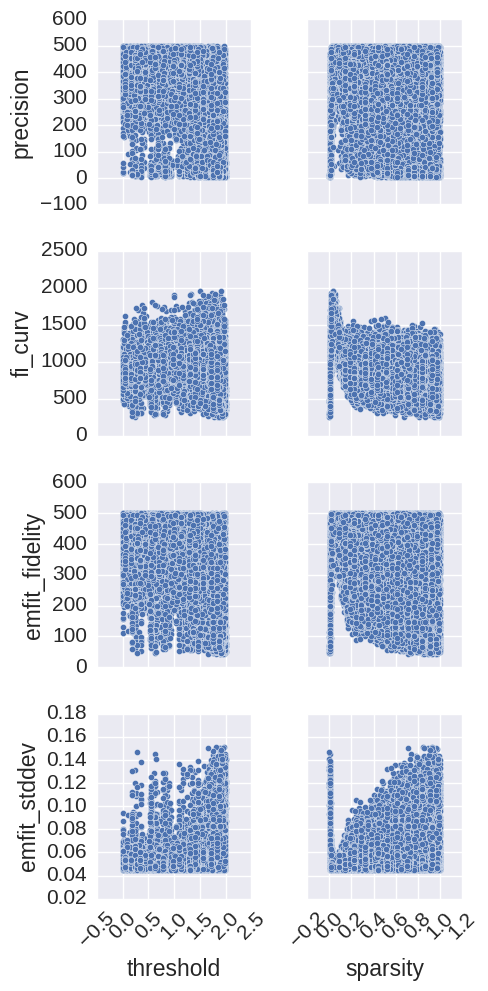

In [77]:
# Cross-correlation plots
g = sns.pairplot(
    df_fits_filtered,
    x_vars=parameter_names_sorted,
    y_vars=['precision', 'fi_curv', 'emfit_fidelity', 'emfit_stddev']
)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize and do some plots

In [174]:
nQuantiles = 51

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(
    df_fits_filtered, parameter_names_sorted, nQuantiles)

## 2D plot M/ratio_conj

In [175]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None, ax=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    
    return utils.plot_mean_std_area(df_mean[x_col], #param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel,
                                    ax_handle=ax,
                                    label=y_col
                                   )

In [176]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if interpolate_column + "_std" in df:
        w = 1./df[interpolate_column + "_std"]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', x_int_space=None, y_int_space=None,
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    if x_int_space is None:
        x_int_space = np.sort(df[x_col].unique())
    if y_int_space is None:
        y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [177]:
df_avgstd = df_quantized.groupby(parameter_names_sorted, as_index=False).agg(('mean', 'std')).reset_index()
df_avgstd.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_avgstd.columns.values]
df_avgstd.columns = [s.split('_mean')[0] for s in df_avgstd.columns]


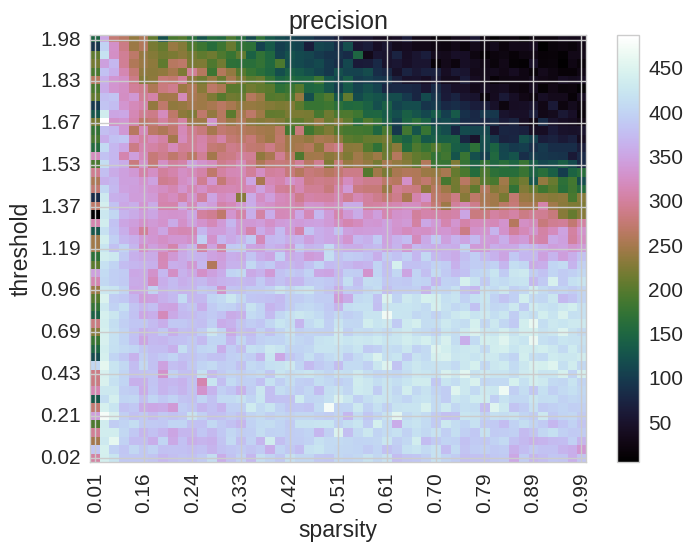

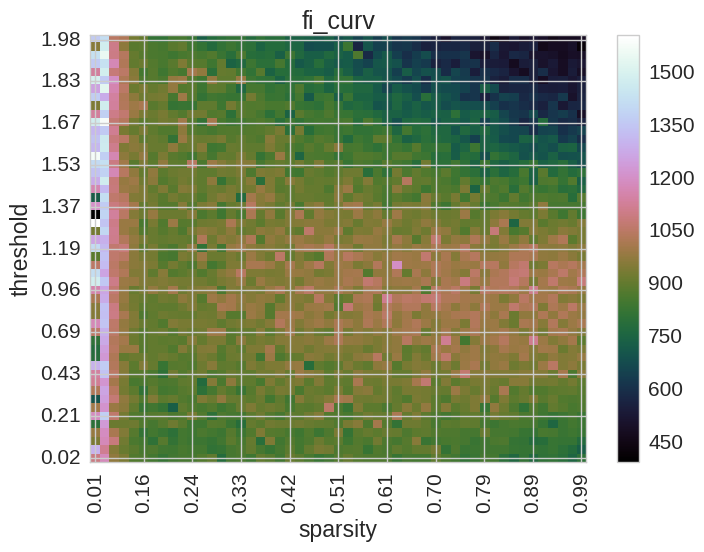

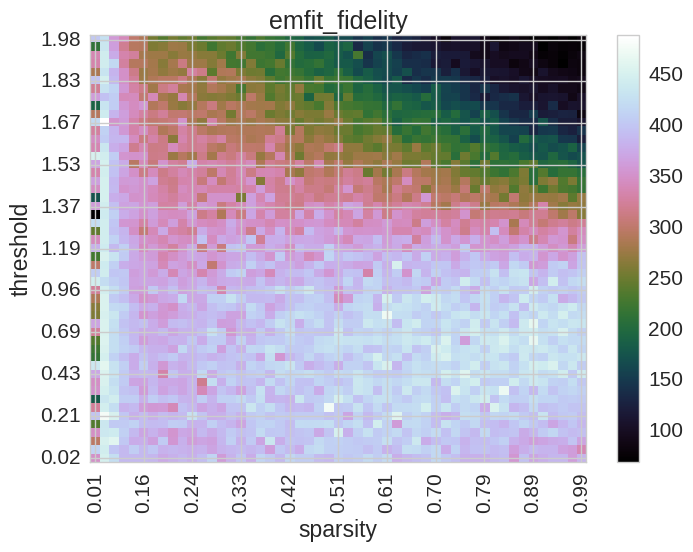

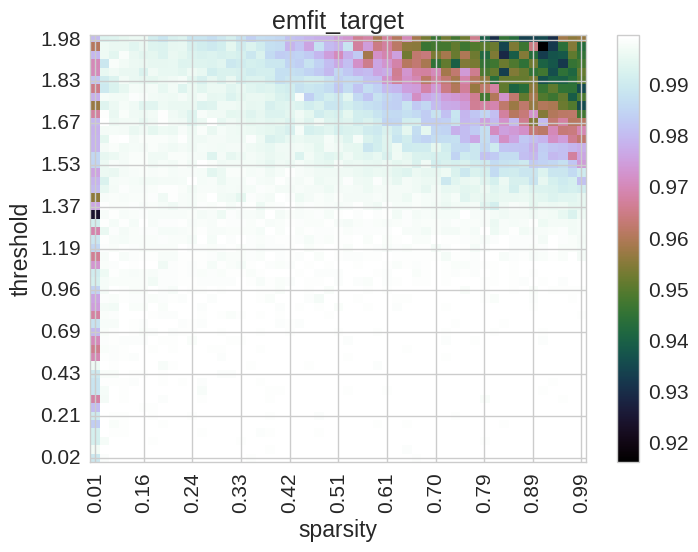

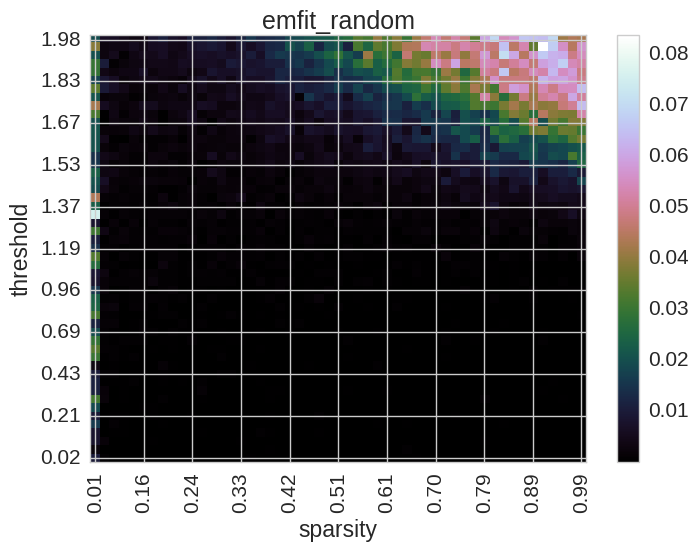

In [181]:
values = ['precision', 'fi_curv', 'emfit_fidelity', 'emfit_target', 'emfit_random']

for value in values:
    params = ('sparsity', 'threshold')
    
    # Get 2d array
    data_pivot = df_avgstd.pivot_table(index="{}_qi".format(params[0]), columns="{}_qi".format(params[1]), 
                                       values=value).as_matrix()
    
    # Replace NaN with local averages
    kernel = asconv.Gaussian2DKernel(stddev=1)
    data_avg = asconv.convolve(data_pivot, kernel, boundary='extend')
    data_pivot[np.isnan(data_pivot)] = data_avg[np.isnan(data_pivot)]
    
    with sns.axes_style('whitegrid'):
        ax, _ = utils.pcolor_2d_data(data_pivot, x=param_qbins_middle[params[0]], y=param_qbins_middle[params[1]], 
                                     ticks_interpolate=11, cmap='cubehelix', xlabel=params[0], ylabel=params[1], 
                                     title=value)

    ax.figure.savefig(dataio.create_formatted_filename(
        "sparsitythreshold_2d_%s_{label}_{unique_id}.pdf" % value), bbox_inches='tight')
    

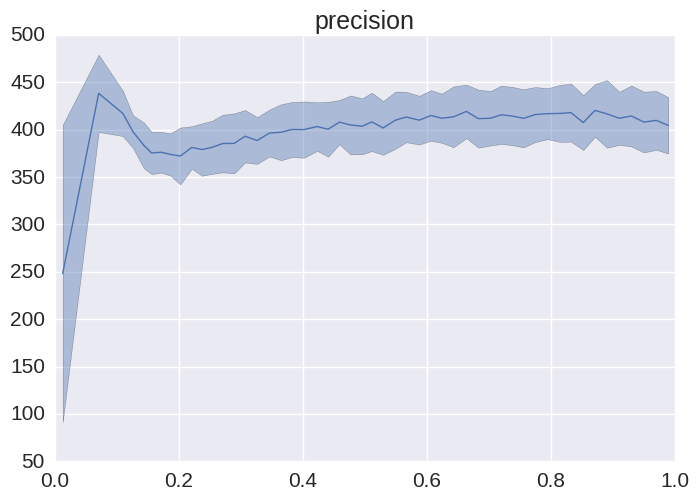

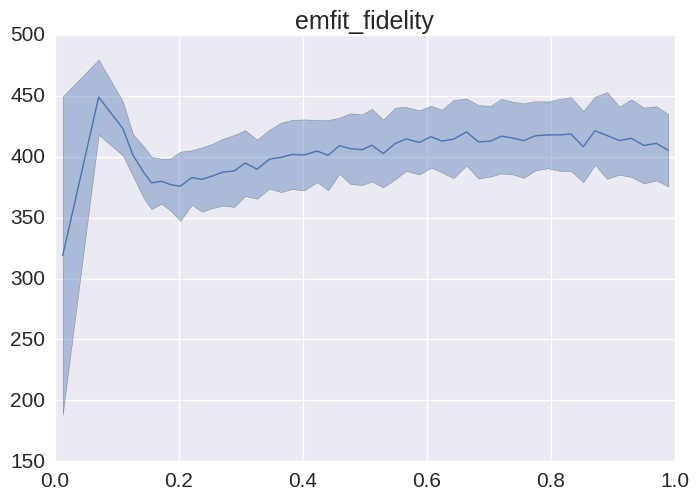

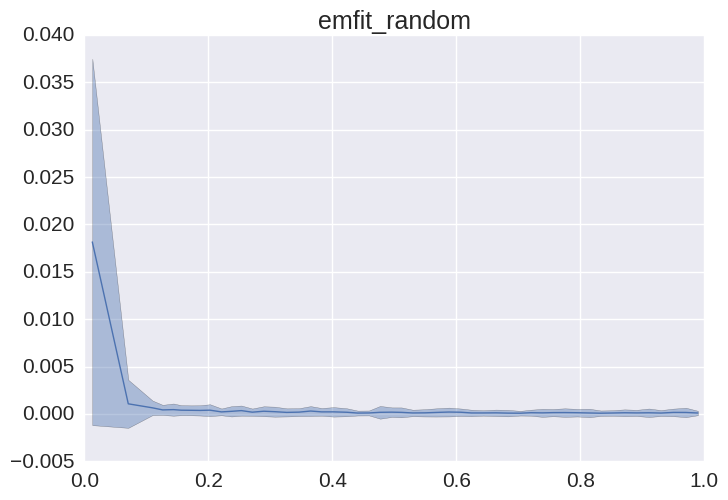

In [182]:
df_goodthresholds = df_avgstd[df_avgstd.threshold < 1.1]

for value in ['precision', 'emfit_fidelity', 'emfit_random']:
    ax = plot_mean_std_df(df_goodthresholds, 'sparsity', value, param_qbins_middle)
    ax.set_title(value)
    
    ax.figure.savefig(dataio.create_formatted_filename(
        "sparsity_%s_{label}_{unique_id}.pdf" % value), bbox_inches='tight')


In [170]:
# top parameters:

print "Sparse region"
print df_avgstd.sort_values('precision', ascending=False).head(3)[
    parameter_names_sorted + ['precision', 'emfit_target', 'fi_curv']]

print "Dense region"
df_nonsparse = df_avgstd[df_avgstd.sparsity > 0.1]
print df_nonsparse.sort_values('precision', ascending=False).head(3)[
    parameter_names_sorted + ['precision', 'emfit_target', 'fi_curv']]

Sparse region
      threshold  sparsity   precision  emfit_target      fi_curv
716    0.202694  0.036689  499.715372           1.0  1507.628829
4558   1.256204  0.047856  499.387482           1.0  1316.638161
2616   0.699608  0.769912  499.301686           1.0  1073.586686
Dense region
      threshold  sparsity   precision  emfit_target      fi_curv
2616   0.699608  0.769912  499.301686           1.0  1073.586686
2564   0.688491  0.934933  492.557132           1.0  1220.455465
2352   0.635248  0.821312  491.117043           1.0  1134.629619
